In [1]:
# download the image dataset and clone the git repo hosting the code for the model and other utilities for processing the data
import os
if not os.path.exists('open-images-bus-trucks'):
  %pip install -q torch_snippets
  !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
  !tar -xf open-images-bus-trucks.tar.xz
  !rm open-images-bus-trucks.tar.xz
  !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.4 MB/s eta 0:00:00
Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting o

In [2]:
# preprocess the data
from torch_snippets import *
import glob
DATA_ROOT = '../open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else  'cpu'

In [3]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255])

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  img = normalize(img)
  return img.to(device).float()

# prepare a dataset class
class OpenDataset(torch.utils.data.Dataset):
  w, h = 300, 300
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'/*')
    self.df = df
    self.image_infos = df.ImageID.unique()
    logger.info(f'{len(self)} items loaded')

  def __getitem__(self, ix):
    # load images and masks
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    img = Image.open(img_path).convert("RGB")
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
    data = df[df['ImageID'] == image_id]
    labels = data['LabelName'].values.tolist()
    data = data[['XMin','YMin','XMax','YMax']].values
    data[:,[0,2]] *= self.w
    data[:,[1,3]] *= self.h
    boxes = data.astype(np.uint32).tolist()
    return img, boxes, labels

  def collate_fn(self, batch):
    images, boxes, labels = [], [], []
    for item in batch:
      img, image_boxes, image_labels = item
      img = preprocess_image(img)[None]
      images.append(img)
      boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
      labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
    images = torch.cat(images).to(device)
    return images, boxes, labels

  def __len__(self):
    return len(self.image_infos)

In [4]:
# prepare training and testing dataloaders
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

[11/04/25 03:30:48] INFO     13702 items loaded                                                                                      ]8;id=184804;file:///tmp/ipython-input-2743294559.py:20\ipython-input-2743294559.py]8;;\:]8;id=140961;file:///tmp/ipython-input-2743294559.py:20#__init__:20\__init__:20]8;;\

                    INFO     1523 items loaded                                                                                       ]8;id=550711;file:///tmp/ipython-input-2743294559.py:20\ipython-input-2743294559.py]8;;\:]8;id=752299;file:///tmp/ipython-input-2743294559.py:20#__init__:20\__init__:20]8;;\

In [5]:
# define functions to train on a batch of data and calculate the accuracy and loss values on the validation data
def train_batch(inputs, model, criterion, optmizer):
  model.train()
  N = len(train_loader)
  images, boxes, labels = inputs
  _regr, _clss = model(images)
  loss = criterion(_regr, _clss, boxes, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
  model.eval()
  images, boxes, labels = inputs
  _regr, _clss = model(images)
  loss = criterion(_regr, _clss, boxes, labels)
  return loss

In [6]:
# import the model
from model import SSD300, MultiBoxLoss
from detect import *

In [7]:
# initialize the model, optimizer, and loss function
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.8MB/s]



Loaded base model.



/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [8]:
# train the model over increasing epochs
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    pos = (epoch + (ix+1)/_n)
    log.record(pos, trn_loss=loss.item(), end='\r')

  _n = len(test_loader)
  for ix, inputs in enumerate(test_loader):
    loss = validate_batch(inputs, model, criterion)
    pos = (epoch + (ix+1)/_n)
    log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 3.000  val_loss: 1.772  (2166.40s - 0.00s remaining)

In [9]:
# fetch a random image
image_paths = Glob(f'{DATA_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

[11/04/25 04:07:03] INFO     Chose `1e450395f64c87c6` from input                                                                                          ]8;id=418836;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138\logger.py]8;;\:]8;id=749525;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138#Info:138\Info:138]8;;\

[11/04/25 04:32:51] INFO     Chose `16b2639dc73c2d98` from input                                                                                          ]8;id=481725;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138\logger.py]8;;\:]8;id=365782;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138#Info:138\Info:138]8;;\

[[50, 68, 247, 136]] ['Truck @ 0.93']


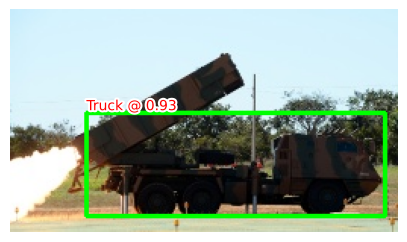

                    INFO     Chose `84731277fd0ce72b` from input                                                                                          ]8;id=664014;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138\logger.py]8;;\:]8;id=708319;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138#Info:138\Info:138]8;;\

[[86, 77, 210, 162], [3, 91, 60, 148]] ['Bus @ 1.00', 'Bus @ 0.95']


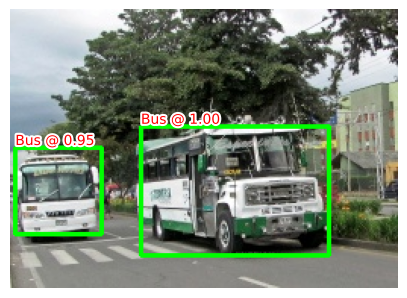

                    INFO     Chose `66e7d5eeeea529b6` from input                                                                                          ]8;id=313144;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138\logger.py]8;;\:]8;id=66772;file:///usr/local/lib/python3.12/dist-packages/torch_snippets/logger.py:138#Info:138\Info:138]8;;\

[[11, 22, 237, 171]] ['Truck @ 0.99']


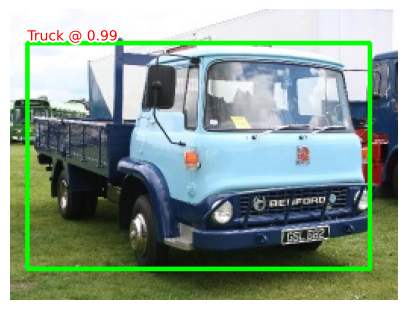

In [13]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    # fetch the bounding box, label and score corresponding to the objects present in the image
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    # overlay the obtained output on the image
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)